In [11]:
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
from lib.utils.timer import Timer
from lib.fast_rcnn.config import cfg
from lib.fast_rcnn.test import  test_ctpn
from lib.networks.factory import get_network
from lib.text_connector.detectors import TextDetector
from lib.text_connector.text_connect_cfg import Config as TextLineCfg


def resize_im(im, scale, max_scale=None):
    f = float(scale) / min(im.shape[0], im.shape[1])
    if max_scale != None and f * max(im.shape[0], im.shape[1]) > max_scale:
        f = float(max_scale) / max(im.shape[0], im.shape[1])
    return cv2.resize(im, None, None, fx=f, fy=f, interpolation=cv2.INTER_LINEAR), f

def load_tf_model():
    # load config file
    cfg.TEST.checkpoints_path = './checkpoints'

    # init session
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1.0)
    config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)
    sess = tf.Session(config=config)

    # load network
    net = get_network("VGGnet_test")

    # load model
    print('Loading network {:s}... '.format("VGGnet_test"))
    saver = tf.train.Saver()
    # print(cfg.TEST.checkpoints_path)
    # input()
    try:
        ckpt = tf.train.get_checkpoint_state(cfg.TEST.checkpoints_path)
        print('Restoring from {}...'.format(ckpt.model_checkpoint_path))
        saver.restore(sess, ckpt.model_checkpoint_path)
        print('done')
    except:
        raise 'Check your pretrained {:s}'.format(ckpt.model_checkpoint_path)

    return sess, net

sess, net = load_tf_model()

def ctpn(img):
    timer = Timer()
    timer.tic()

    img, scale = resize_im(img, scale=TextLineCfg.SCALE, max_scale=TextLineCfg.MAX_SCALE)
    scores, boxes = test_ctpn(sess, net, img)

    textdetector = TextDetector()
    boxes = textdetector.detect(boxes, scores[:, np.newaxis], img.shape[:2])
    timer.toc()
    print("\n----------------------------------------------")
    print(('Detection took {:.3f}s for '
           '{:d} object proposals').format(timer.total_time, boxes.shape[0]))

    return scores, boxes, img, scale

def draw_boxes(img, boxes, scale):
    box_id = 0
    img = img.copy()
    text_recs = np.zeros((len(boxes), 8), np.int)
    for box in boxes:
        if np.linalg.norm(box[0] - box[1]) < 5 or np.linalg.norm(box[3] - box[0]) < 5:
            continue

        if box[8] >= 0.8:
            color = (255, 0, 0)  # red
        else:
            color = (0, 255, 0)  # green

        cv2.line(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
        cv2.line(img, (int(box[0]), int(box[1])), (int(box[4]), int(box[5])), color, 2)
        cv2.line(img, (int(box[6]), int(box[7])), (int(box[2]), int(box[3])), color, 2)
        cv2.line(img, (int(box[4]), int(box[5])), (int(box[6]), int(box[7])), color, 2)

        for i in range(8):
            text_recs[box_id, i] = box[i]

        box_id += 1

    img = cv2.resize(img, None, None, fx=1.0/scale, fy=1.0/scale, interpolation=cv2.INTER_LINEAR)
    return text_recs, img

def text_detect(img):
    scores, boxes, img, scale = ctpn(img)
    text_recs, img_drawed = draw_boxes(img, boxes, scale)
    return text_recs, img_drawed, img

Tensor("Placeholder:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("conv5_3/conv5_3:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_conv/3x3/rpn_conv/3x3:0", shape=(?, ?, ?, 512), dtype=float32)
Instructions for updating:
Use the retry module or similar alternatives.
Tensor("lstm_o/Reshape_2:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("lstm_o/Reshape_2:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_cls_score/Reshape_1:0", shape=(?, ?, ?, 20), dtype=float32)
Tensor("rpn_cls_prob:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("Reshape_2:0", shape=(?, ?, ?, 20), dtype=float32)
Tensor("rpn_bbox_pred/Reshape_1:0", shape=(?, ?, ?, 40), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 3), dtype=float32)
Loading network VGGnet_test... 
Restoring from ./checkpoints/VGGnet_fast_rcnn_iter_50000.ckpt...
INFO:tensorflow:Restoring parameters from ./checkpoints/VGGnet_fast_rcnn_iter_50000.ckpt
done


In [12]:
from PIL import Image
from lib.fast_rcnn.config import cfg_from_file
import matplotlib.pyplot as plt
%matplotlib inline
cfg_from_file('./ctpn/text.yml')


----------------------------------------------
Detection took 4.198s for 10 object proposals


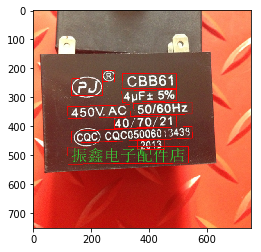


----------------------------------------------
Detection took 2.298s for 9 object proposals


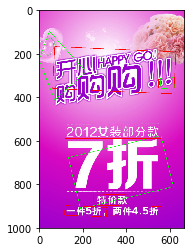


----------------------------------------------
Detection took 2.037s for 5 object proposals


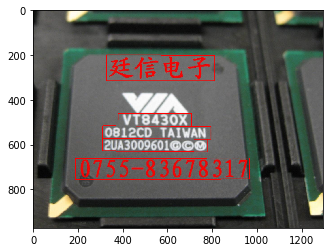


----------------------------------------------
Detection took 1.650s for 9 object proposals


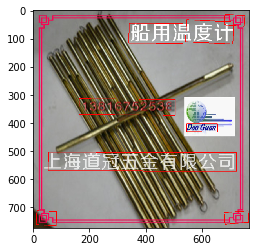


----------------------------------------------
Detection took 0.398s for 12 object proposals


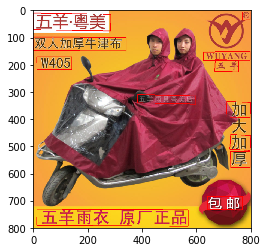


----------------------------------------------
Detection took 1.662s for 6 object proposals


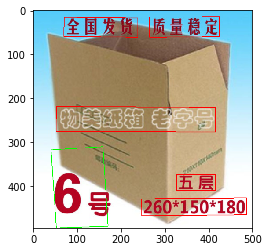


----------------------------------------------
Detection took 2.045s for 7 object proposals


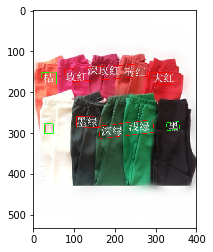


----------------------------------------------
Detection took 0.386s for 7 object proposals


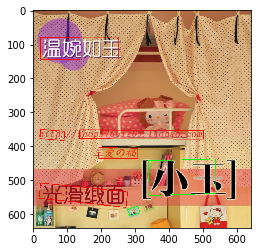


----------------------------------------------
Detection took 0.384s for 5 object proposals


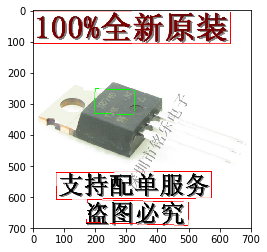


----------------------------------------------
Detection took 2.049s for 10 object proposals


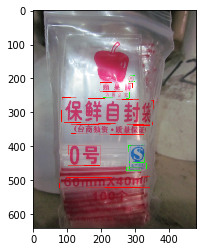

In [13]:
counter = 0
for i in ['./tianchi_ocr/' + i for i in os.listdir('./tianchi_ocr/')]:
    im = Image.open(i)
    img = np.array(im.convert('RGB'))
    text_recs, img_drawed, img = text_detect(img)
#     Image.fromarray(img_drawed).save('result.jpg')
    with open(os.path.join('results', i.split('/')[-1][:-3])+'txt', 'w') as fout:
        for j in text_recs:
            for k in range(j.shape[0]-1):
                fout.write(str(j[k])+',')
            fout.write(str(j[k+1])+'\n')
    if not counter % 1000:
        plt.imshow(img_drawed)
        plt.show()
    counter += 1